In [1]:
# !pip install pandas

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

#set plot properties
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(context = 'notebook', style = 'darkgrid', palette = 'deep', font = 'Helvetica')

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('../data/_fasr_data_cleaned_v2.csv')

# pre processing - scale ripple & efficiency
df['o1'] = df['o1']*100
df['o2'] = df['o2']/100
df.head()

,o1,o2,o3,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,18.664571,0.912755,7.320161,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
1,15.820381,0.910424,7.482942,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
2,21.132775,0.910279,7.586356,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
3,8.800834,0.908270,7.762458,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
4,10.378489,0.908696,7.833571,1,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1


In [4]:
"""
for ind in range(1, 13+1):
    print(f"factor{ind} list --> ",df[f'f{ind}'].tolist())

for ind in range(1, 3+1):
    print(f"output{ind} list --> ",df[f'o{ind}'].tolist())
"""

'\nfor ind in range(1, 13+1):\n    print(f"factor{ind} list --> ",df[f\'f{ind}\'].tolist())\n\nfor ind in range(1, 3+1):\n    print(f"output{ind} list --> ",df[f\'o{ind}\'].tolist())\n'

## Calculate factor effect Values

In [5]:
def get_factor_effect(factor_list, output_list, max_inp=1, min_inp=-1):  
    # same as 2factor2levels code
    mean_weightage = len(output_list)/2
    
    pos_effect = 0
    pos_counts = 0
    neg_effect = 0
    neg_counts = 0
    for fact_val, out_val in zip(factor_list, output_list):
        if fact_val == max_inp:    
            pos_effect += out_val
            pos_counts += 1
        
        elif fact_val == min_inp:
            neg_effect -= out_val
            neg_counts += 1
    
        else:
            print("something wrong in input")
    
    total_counts = pos_counts + neg_counts
    factor_effect = (pos_effect*neg_counts/total_counts) + (neg_effect*pos_counts/total_counts)
    # print('counts ', pos_counts, neg_counts)
    # print('effects ', pos_effect, neg_effect)
    
    return factor_effect/mean_weightage

In [6]:
_factor_names = [f'f{ind}' for ind in range(1, 13+1)]
_output_names = [f'o{ind}' for ind in range(1, 3+1)]

# rows are f1, f2, .. 13 rows, cols are o1, o2 .. 3 columns
output_df = pd.DataFrame(np.nan, columns=_output_names, index=_factor_names)

for factor_name, _row in output_df.iterrows():
    for output_name in _row.keys():
        _factor_effect = get_factor_effect(df[factor_name].tolist(), df[output_name].tolist())
        output_df.loc[factor_name][output_name] = _factor_effect


In [7]:
output_df['o_com'] = 0
for output_name in _output_names:
    output_df['o_com'] += abs(output_df[output_name])
output_df['o_com'] = output_df['o_com']/len(_output_names)

com_avg = output_df['o_com'].mean()
print(f'average of composite factor is {com_avg}\n\n')
print(output_df)

average of composite factor is 1.0514773574829432


           o1        o2        o3     o_com
f1   0.652043  0.000080 -0.021016  0.224380
f2   2.261710  0.000399 -0.074411  0.778840
f3   0.022290  0.000090 -0.021373  0.014584
f4  -4.294196  0.000221  0.074510  1.456309
f5  -1.590756  0.000552  0.064809  0.552039
f6   4.855269  0.000287 -0.071751  1.642436
f7   5.641002 -0.000047 -0.091588  1.910879
f8   5.541243 -0.000110 -0.089541  1.876965
f9   5.288502  0.000037 -0.098243  1.795594
f10 -1.945234 -0.000115 -0.031650  0.659000
f11  2.944511  0.000390  0.020520  0.988474
f12  2.495853  0.000430  0.063556  0.853280
f13  2.700374  0.000337  0.048570  0.916427


In [8]:
output_df.to_csv('../data/results_v2.csv')

In [9]:
# df['f6'].value_counts()

In [10]:
#  get_factor_effect(df['f6'].tolist(), df['o1'].tolist())

## calculate interaction effects

In [11]:
def get_factors_interaction_effect(factor1_list, factor2_list, output_list, max_inp=1, min_inp=-1):
    if not(set(factor1_list) == set(factor2_list) == {-1, 1}):
        raise ValueError('invalid factor values')

    high_interaction = 0
    low_interaction = 0
    high_counts = 0
    low_counts = 0
    mean_weightage = len(output_list) / 2

    for f1_val, f2_val, out_val in zip(factor1_list, factor2_list, output_list):
        if f2_val == max_inp:
            high_interaction = high_interaction + out_val if f1_val == max_inp else high_interaction - out_val
            high_counts += 1

        elif f2_val == min_inp:
            low_interaction = low_interaction + out_val if f1_val == max_inp else low_interaction - out_val
            low_counts += 1

    total_counts = high_counts + low_counts
#     interaction_effect = (high_interaction*low_counts/total_counts) + (low_interaction*high_counts/total_counts)
    interaction_effect = high_interaction - low_interaction

    interaction_effect = interaction_effect / mean_weightage
    return interaction_effect

In [12]:
# rows are f1, f2, .. 13 rows, cols are f1, f2, .. 13 columns
output_int_dfs = dict.fromkeys(_output_names, None)

for output_name in _output_names:
    _output_int_df = pd.DataFrame(np.nan, columns=_factor_names, index=_factor_names)
    
    for factor1_name, _row in _output_int_df.iterrows():
        for factor2_name in _row.keys():
            _factor_int_effect = 0
            if factor1_name != factor2_name:
                _factor_int_effect = get_factors_interaction_effect(
                    df[factor1_name].tolist(), 
                    df[factor2_name].tolist(), 
                    df[output_name].tolist()
                )
            _output_int_df.loc[factor1_name][factor2_name] = _factor_int_effect
#             _output_int_df.loc[factor2_name][factor1_name] += _factor_int_effect
    
    output_int_dfs[output_name] = _output_int_df

In [13]:
output_int_dfs['o1']

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
f1,0.000000,28.412681,40.627231,-19.067876,-20.524344,20.517342,12.596489,11.415007,13.528097,32.764325,29.778281,23.643824,26.344117
f2,28.412681,0.000000,31.973835,-18.143060,-9.341539,25.054408,17.133554,15.952072,18.065162,21.581520,33.446364,27.311907,30.012199
f3,40.627231,31.973835,0.000000,-15.506722,-21.556089,16.956189,9.035335,7.853853,9.966943,33.796070,30.810026,24.675569,27.375861
f4,-19.067876,-18.143060,-15.506722,0.000000,27.062310,-23.322073,-28.947454,-27.765972,-24.280264,-7.643817,-19.508661,-13.374204,-16.074496
f5,-20.524344,-9.341539,-21.556089,27.062310,0.000000,-12.442644,-15.553035,-14.371553,-10.885845,-13.693183,-10.707139,-4.572682,-7.272975
f6,20.517342,25.054408,16.956189,-23.322073,-12.442644,0.000000,29.725112,28.543630,25.057922,9.093283,30.334547,24.200090,26.900383
f7,12.596489,17.133554,9.035335,-28.947454,-15.553035,29.725112,0.000000,38.142855,34.363029,1.172430,22.413694,16.279237,18.979529
f8,11.415007,15.952072,7.853853,-27.765972,-14.371553,28.543630,38.142855,0.000000,37.246687,-0.009052,21.232212,15.097755,17.798047
f9,13.528097,18.065162,9.966943,-24.280264,-10.885845,25.057922,34.363029,37.246687,0.000000,2.104037,23.345302,17.210844,19.911137
f10,32.764325,21.581520,33.796070,-7.643817,-13.693183,9.093283,1.172430,-0.009052,2.104037,0.000000,22.947120,16.812663,19.512956


In [14]:
def scale_interaction_effects(df_raw, feature_range):
    # Using MinMaxScaler
    df_len = len(df_raw)
    min_max_scaler = MinMaxScaler(feature_range=feature_range)
    
    # Stack everything into a single column to scale by the global min / max
    tmp = df_raw.to_numpy().reshape(-1,1)
    mid_value = (df_raw.max().max() + df_raw.min().min())/2
    tmp = np.where(tmp == 0, mid_value, tmp)
    
    scaled_values = min_max_scaler.fit_transform(tmp).reshape(df_len, df_len)
    scaled_values = np.round(scaled_values, 4)
    scaled_values = np.where(scaled_values == 0, 0, scaled_values)
    
    return pd.DataFrame(scaled_values, columns=df_raw.columns, index=df_raw.index)

In [15]:
factor_name_map = {
 'f1': 'h1',
 'f2': 'h2',
 'f3': 'h3',
 'f4': 'theta1',
 'f5': 'theta2',
 'f6': 'theta3',
 'f7': 'delta1',
 'f8': 'delta2',
 'f9': 'delta3',
 'f10': 'ag',
 'f11': 'l1',
 'f12': 'l2',
 'f13': 'l3'
}
output_name_map = {
 'o1': 'T ripple',
 'o2': 'Efficiency',
 'o3': 'T avg',
}

In [16]:
xy_ticks = [factor_name_map[f] for f in _factor_names]
xy_ticks_mod = [
    r'$h_{1}$', # 'h\N{SUBSCRIPT ONE}'
    r'$h_{2}$', # 'h\N{SUBSCRIPT TWO}'
    r'$h_{3}$', # 'h\N{SUBSCRIPT THREE}'
    '$\N{GREEK SMALL LETTER THETA}_{1}$', # '\N{GREEK SMALL LETTER THETA}\N{SUBSCRIPT ONE}'
    '$\N{GREEK SMALL LETTER THETA}_{2}$',   # '\N{GREEK SMALL LETTER THETA}\N{SUBSCRIPT TWO}'
    '$\N{GREEK SMALL LETTER THETA}_{3}$',   # '\N{GREEK SMALL LETTER THETA}\N{SUBSCRIPT THREE}'
    '$\N{GREEK SMALL LETTER DELTA}_{1}$',  # '\N{GREEK SMALL LETTER DELTA}\N{SUBSCRIPT ONE}'
    '$\N{GREEK SMALL LETTER DELTA}_{2}$',   # '\N{GREEK SMALL LETTER DELTA}\N{SUBSCRIPT TWO}'
    '$\N{GREEK SMALL LETTER DELTA}_{3}$',  # '\N{GREEK SMALL LETTER DELTA}\N{SUBSCRIPT THREE}'
    'g', 
    r'$w_{1}$', # 'w\N{SUBSCRIPT ONE}'
    r'$w_{2}$',  # 'w\N{SUBSCRIPT TWO}'
    r'$w_{3}$' #  'w\N{SUBSCRIPT THREE}'
]
output_name_map_mod = {
    'o1': '$T_{ripple}$',
    'o2': 'Efficiency',
    'o3': '$T_{av}$',
}
print(xy_ticks_mod)


['$h_{1}$', '$h_{2}$', '$h_{3}$', '$θ_{1}$', '$θ_{2}$', '$θ_{3}$', '$δ_{1}$', '$δ_{2}$', '$δ_{3}$', 'g', '$w_{1}$', '$w_{2}$', '$w_{3}$']


In [17]:
cbar_ticks = [x/10 for x in range(-10, 12, 2)]

# mask = np.zeros((13, 13))
# mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2)

f,ax = plt.subplots(1,3,figsize=(45,15), dpi = 300, facecolor='w', edgecolor='k')
for ind, _out in enumerate(_output_names):
    value_to_map = output_int_dfs[_out]
    value_to_map = scale_interaction_effects(output_int_dfs[_out], feature_range=(-1, 1))
    
    # assign into subplot
    ax[ind] = sns.heatmap(value_to_map, annot=True, cmap='RdYlGn',linewidths=0.4,
                          cbar_kws={'label': 'scale', 'ticks': cbar_ticks},
                          xticklabels = xy_ticks_mod, yticklabels = xy_ticks_mod, annot_kws={"size": 20},
                          ax=ax[ind]).set_title(f"\nFactor interaction effects: {output_name_map_mod[_out]}\n",fontsize=30)
plt.show()

## Inference charts

In [18]:
feature_range = (-1, 1)
min_max_scaler = MinMaxScaler(feature_range=feature_range)
scaled_output_df = pd.DataFrame()
scaled_output_df['factor'] = [factor_name_map[_factor] for _factor in output_df.index]

for _out in _output_names:
    scaled_values = min_max_scaler.fit_transform(output_df[_out].to_numpy().reshape(-1,1))
    scaled_output_df[_out] = scaled_values.squeeze()

scaled_output_df

,factor,o1,o2,o3
0,h1,-0.004300,-0.414779,-0.105930
1,h2,0.319733,0.542941,-0.724096
2,h3,-0.131072,-0.386337,-0.110062
3,theta1,-1.000000,0.007100,1.000000
4,theta2,-0.455785,1.000000,0.887689
5,theta3,0.841828,0.205667,-0.693303
6,delta1,1.000000,-0.795806,-0.922954
7,delta2,0.979918,-0.985502,-0.899261
8,delta3,0.929040,-0.546390,-1.000000
9,ag,-0.527143,-1.000000,-0.229042


In [19]:
new_factor_ui_map = {
 'h1': r'$h_{1}$',
 'h2': r'$h_{2}$',
 'h3': r'$h_{3}$',
 'theta1': '$\N{GREEK SMALL LETTER THETA}_{1}$',
 'theta2': '$\N{GREEK SMALL LETTER THETA}_{2}$',
 'theta3': '$\N{GREEK SMALL LETTER THETA}_{3}$',
 'delta1': '$\N{GREEK SMALL LETTER DELTA}_{1}$',
 'delta2': '$\N{GREEK SMALL LETTER DELTA}_{2}$',
 'delta3': '$\N{GREEK SMALL LETTER DELTA}_{3}$',
 'ag': 'g',
 'l1': r'$w_{1}$',
 'l2': r'$w_{2}$',
 'l3': r'$w_{3}$'
}

unrolled_columns = ['Geometric Design Parameters', 'Design Objectives', 'S value']
unrolled_output_df = pd.DataFrame(columns=unrolled_columns)
for _, row in scaled_output_df.iterrows():
    for _out in _output_names:
        _col_values = [new_factor_ui_map[row.factor], output_name_map_mod[_out], eval(f'row.{_out}')]
        _df = dict(zip(unrolled_columns, _col_values))
        unrolled_output_df = unrolled_output_df.append(_df, ignore_index = True)
    
unrolled_output_df.reset_index()
# unrolled_output_df

,index,Geometric Design Parameters,Design Objectives,S value
0,0,$h_{1}$,$T_{ripple}$,-0.004300
1,1,$h_{1}$,Efficiency,-0.414779
2,2,$h_{1}$,$T_{av}$,-0.105930
3,3,$h_{2}$,$T_{ripple}$,0.319733
4,4,$h_{2}$,Efficiency,0.542941
5,5,$h_{2}$,$T_{av}$,-0.724096
6,6,$h_{3}$,$T_{ripple}$,-0.131072
7,7,$h_{3}$,Efficiency,-0.386337
8,8,$h_{3}$,$T_{av}$,-0.110062
9,9,$θ_{1}$,$T_{ripple}$,-1.000000


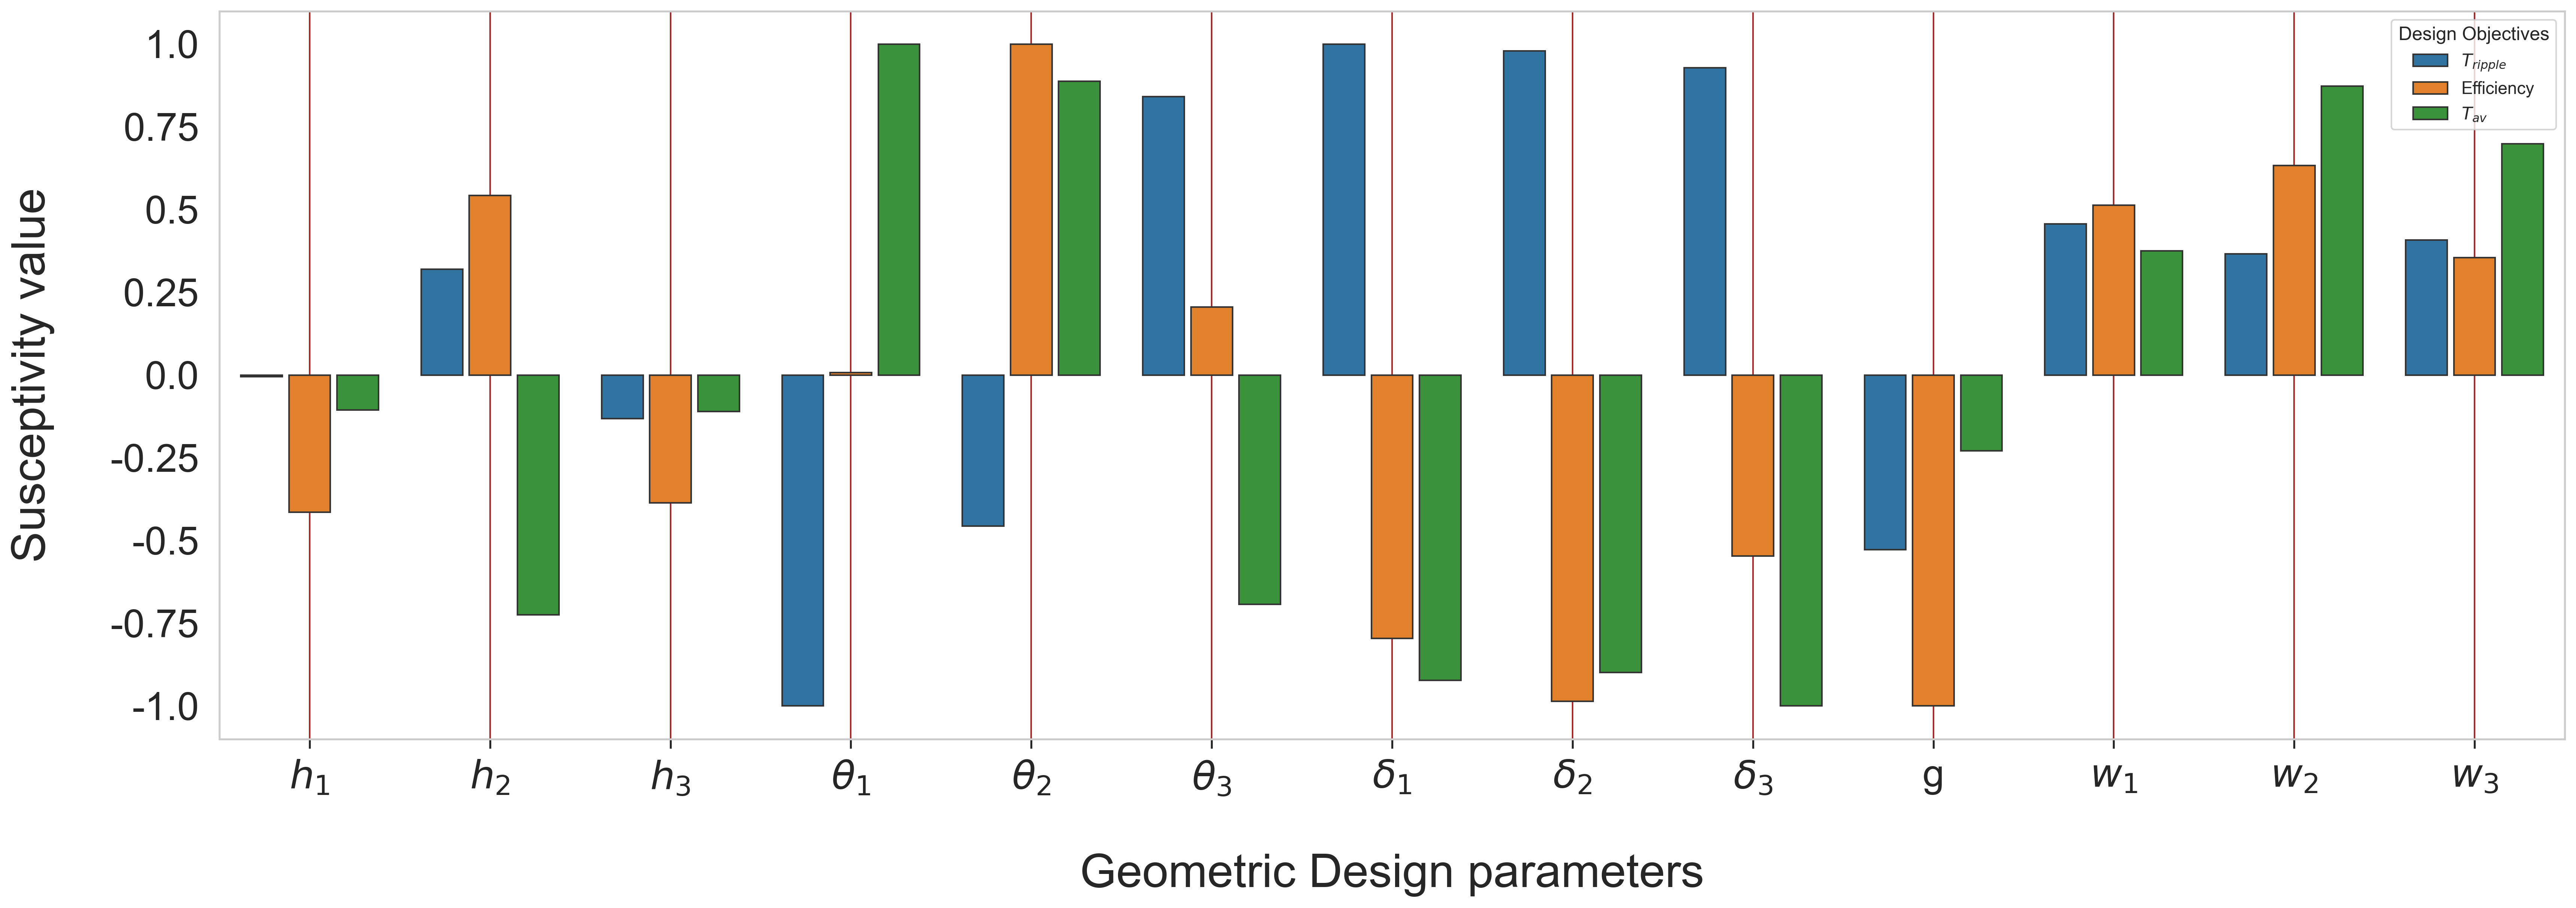

In [20]:
sns.set(font_scale=1)

# figure(figsize=(24, 8), dpi=150)
sns.set_style("whitegrid")
f,ax = plt.subplots(figsize=(24, 8), dpi = 300, facecolor='w', edgecolor='k')
ax = sns.barplot(data=unrolled_output_df, x="Geometric Design Parameters", y="S value", hue="Design Objectives",
                 edgecolor=".2", palette="tab10")

ax.xaxis.set_ticks_position("bottom")
ax.set_yticklabels(ax.get_yticks(), size=25)
_, xlabels = plt.xticks()
ax.set_xticklabels(xlabels, size=25)

ax.set_xlabel("\nGeometric Design parameters",fontsize=30)
ax.set_ylabel("Susceptivity value\n",fontsize=30)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)  # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)  # we recenter the bar
change_width(ax, .23)

plt.grid(color='brown')
plt.show()

In [21]:
# sig_params = ['theta1', 'theta3', 'delta1', 'delta2', 'delta3']
tmp_df = output_df[output_df['o_com'] > com_avg]
sig_params = [factor_name_map[_fact] for _fact in  tmp_df.index]
sig_param_df = scaled_output_df[scaled_output_df['factor'].isin(sig_params)]

sig_param_df.reset_index(inplace=True)
sig_param_df

,index,factor,o1,o2,o3
0,3,theta1,-1.000000,0.007100,1.000000
1,5,theta3,0.841828,0.205667,-0.693303
2,6,delta1,1.000000,-0.795806,-0.922954
3,7,delta2,0.979918,-0.985502,-0.899261
4,8,delta3,0.929040,-0.546390,-1.000000


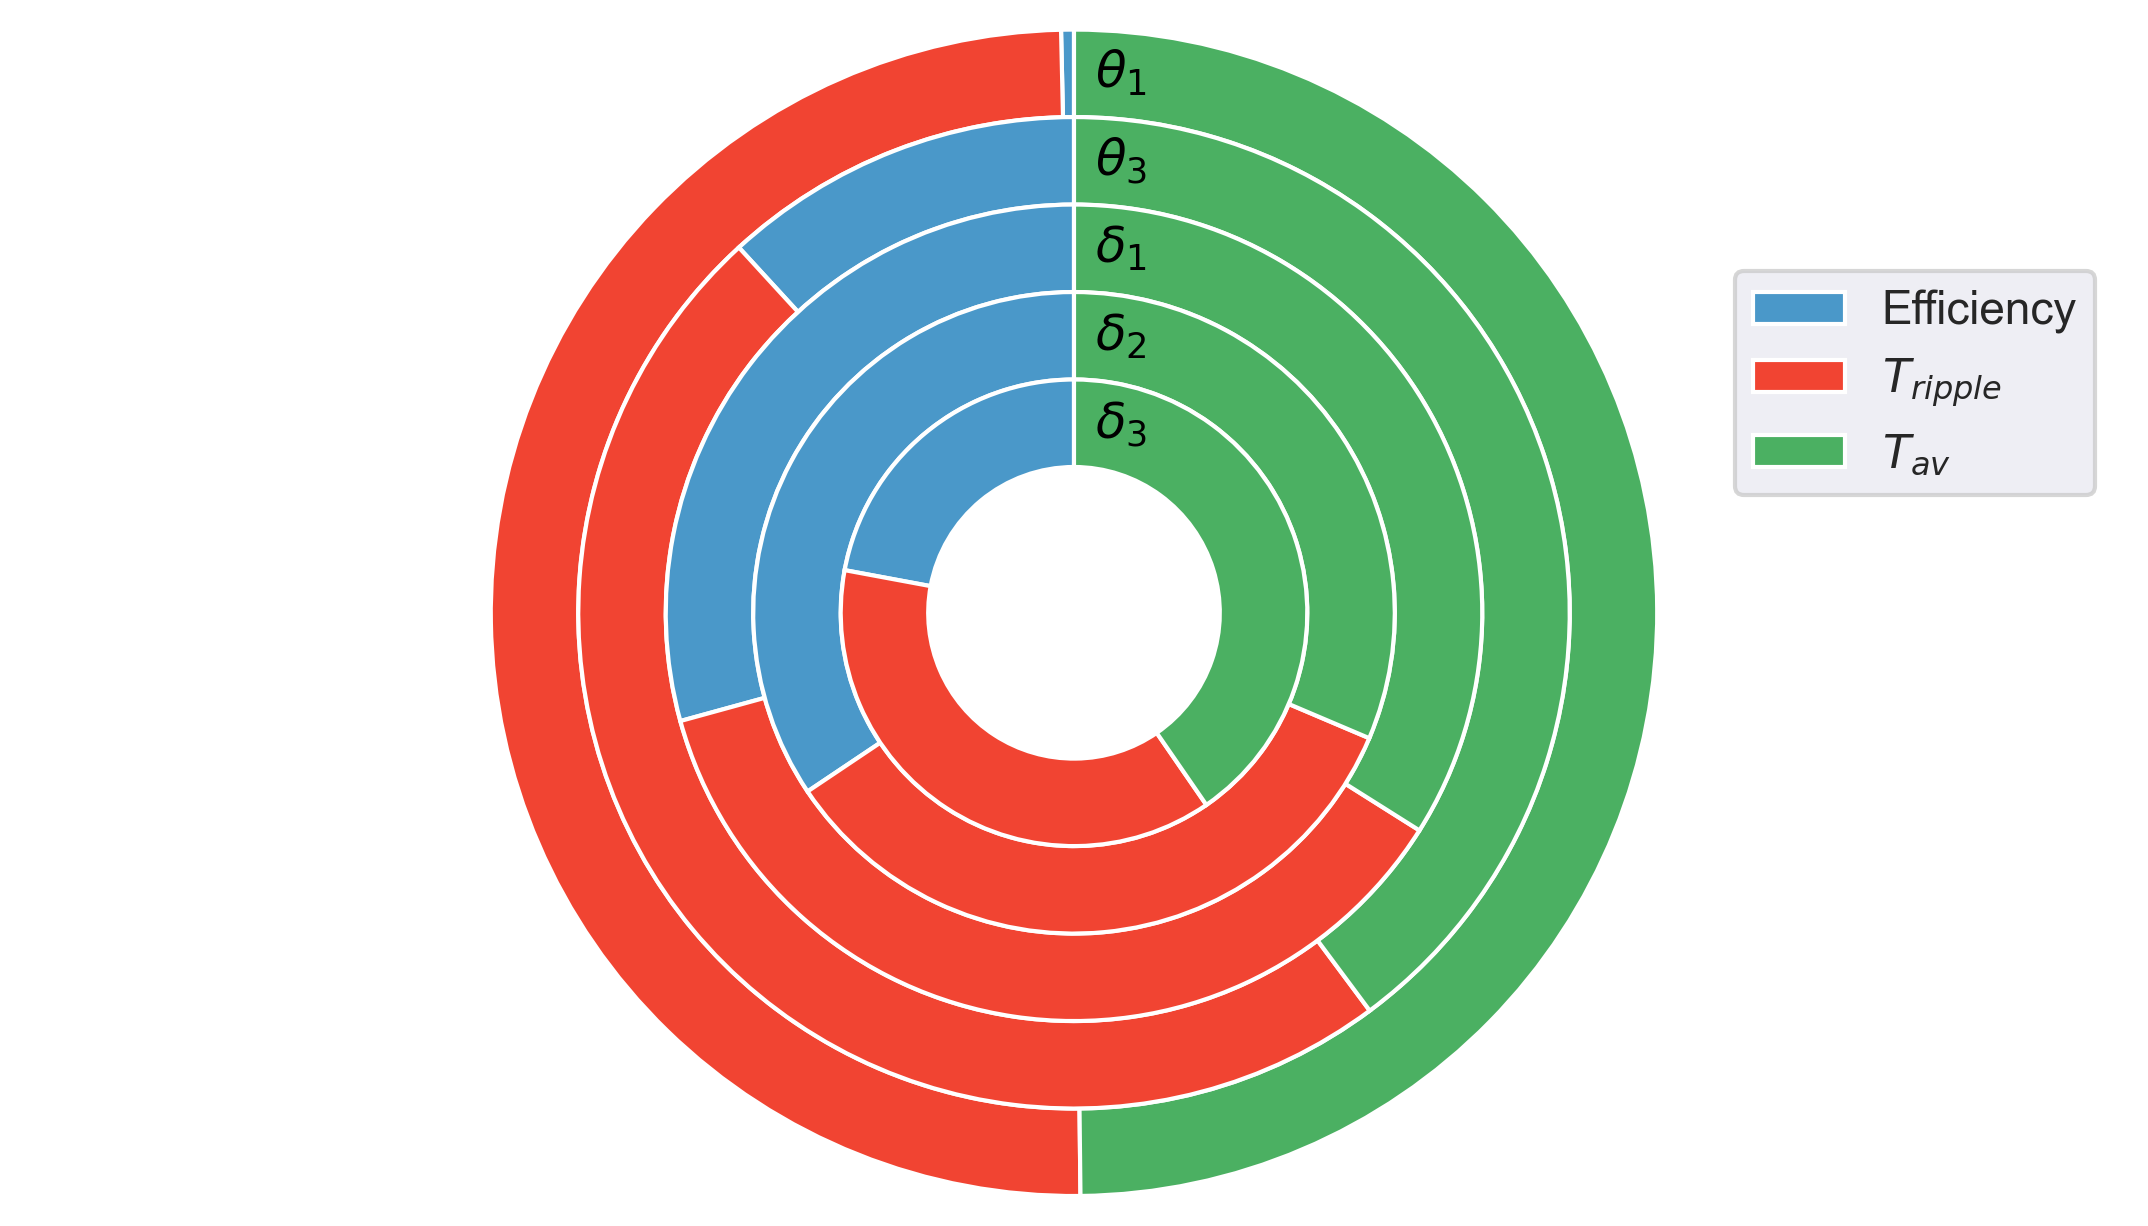

In [22]:
from pylab import text
pie_output_order = ['o2', 'o1', 'o3']
text_start_pos = [1.22, 1.1, 0.98, 0.86, 0.74]

factor_ui_map = {
 'theta1': '$\N{GREEK SMALL LETTER THETA}_{1}$',
 'theta3': '$\N{GREEK SMALL LETTER THETA}_{3}$',
 'delta1': '$\N{GREEK SMALL LETTER DELTA}_{1}$',
 'delta2': '$\N{GREEK SMALL LETTER DELTA}_{2}$',
 'delta3': '$\N{GREEK SMALL LETTER DELTA}_{3}$',
}

sns.set(font_scale=1)

fig, ax = plt.subplots(figsize=(8, 3), dpi = 300, facecolor='w', edgecolor='k')
ax.axis('equal')

a, b, c = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
for ind, row in sig_param_df.iterrows():
    group_size = [abs(eval(f'row.{_out}')) for _out in pie_output_order]
    mypie, _ = ax.pie(group_size, radius=2-ind*0.3, startangle=90, 
                      # labels=group_names,labeldistance=1, pctdistance =0.9,
                      colors=[a(0.6), b(0.6), c(0.6)])
    plt.setp(mypie, width=0.3, edgecolor='white')
    text(0.51, text_start_pos[ind], factor_ui_map[row.factor], color='black', transform=ax.transAxes)

plt.legend([output_name_map_mod[x] for x in pie_output_order])
plt.margins(0,0)
plt.show()